## Face Mask Detection

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
annotationDir = "C:/Users/pavan/Downloads/AI Project/AI Project/archive/Medical mask/Medical mask/Medical Mask/annotations"
imageDir = "C:/Users/pavan/Downloads/AI Project/AI Project/archive/Medical mask/Medical mask/Medical Mask/images"


In [3]:
cvData = cv2.dnn.readNetFromCaffe("C:/Users/pavan/Downloads/AI Project/AI Project/archive/architecture.txt",
                                "C:/Users/pavan/Downloads/AI Project/AI Project/archive/weights.caffemodel")

In [4]:
def getJsonData(location):
    with open(location,'r') as file:
        return json.load(file)

In [5]:
def adjustData(image, gamma=1.0):
    gammaData = 1.0 / gamma
    gammaDataTable = np.array([((i / 255.0) ** gammaData) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), gammaDataTable.astype(np.uint8))

### Data Preprocessing

In [6]:
jsonFileInfo = []
for i in os.listdir(annotationDir):
    jsonFileInfo.append(getJsonData(os.path.join(annotationDir, i)))
    
jsonFileInfo[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:
trainDataFrame = pd.read_csv("C:/Users/pavan/Downloads/AI Project/AI Project/archive/train.csv")
trainDataFrame.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
info = []
imageSize = 124
withMask = ['face_with_mask']
withoutMask = ['face_no_mask']
labels={'mask': 0, 'without mask': 1}
for i in trainDataFrame['name'].unique():
    f = i + '.json'
    for j in getJsonData(os.path.join(annotationDir, f)).get("Annotations"):
        if j['classname'] in withMask:
            x, y, w, h = j['BoundingBox']
            demoImage = cv2.imread(os.path.join(imageDir, i), 1)
            demoImage = demoImage[y:h, x:w]
            demoImage = cv2.resize(demoImage, (imageSize, imageSize))
            info.append([demoImage, labels['mask']])
        if j['classname'] in withoutMask:
            x, y, w, h = j['BoundingBox']
            demoImage = cv2.imread(os.path.join(imageDir, i), 1)
            demoImage = demoImage[y:h, x:w]
            demoImage = cv2.resize(demoImage, (imageSize, imageSize))
            info.append([demoImage, labels['without mask']])
            random.shuffle(info)

In [9]:
len(info)

5749

In [10]:
featureData = []
labelData = []
for features, label in info:
    featureData.append(features)
    labelData.append(label)

In [11]:
featureData[0].shape

(124, 124, 3)

In [12]:
featureData = np.array(featureData) / 255.0
featureData = featureData.reshape(-1, 124, 124, 3)
labelData = np.array(labelData)

In [13]:
np.unique(labelData)

array([0, 1])

In [14]:
labelData.shape

(5749,)

## Training Process

In [15]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3,3), padding='same', 
                              activation=tf.nn.relu, input_shape=(124,124,3)))
model.add(keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu))
model.add(keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(50, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

In [16]:
loss_fn = keras.losses.BinaryCrossentropy()
model.compile(loss=loss_fn,
             optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

In [17]:
x_train, x_val, \
y_train, y_val = train_test_split(featureData, labelData, 
                                train_size=0.8,
                                random_state=0)

In [18]:
datagen = ImageDataGenerator(
                featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False,
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=False
            )

datagen.fit(x_train)

In [19]:
model_hist = model.fit_generator(datagen.flow(x_train, y_train, 
                                             batch_size=32),
                                steps_per_epoch=x_train.shape[0]//32,
                                epochs=5,
                                verbose=1,
                                validation_data=(x_val, y_val))

C:\Users\pavan\AppData\Local\Temp\ipykernel_38240\4239710683.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/5
143/143 [==============================] - 351s 2s/step - loss: 0.3902 - accuracy: 0.8165 - val_loss: 0.2883 - val_accuracy: 0.8878
Epoch 2/5
143/143 [==============================] - 344s 2s/step - loss: 0.2962 - accuracy: 0.8774 - val_loss: 0.2714 - val_accuracy: 0.8870
Epoch 3/5
143/143 [==============================] - 374s 3s/step - loss: 0.2695 - accuracy: 0.8840 - val_loss: 0.2370 - val_accuracy: 0.9070
Epoch 4/5
143/143 [==============================] - 377s 3s/step - loss: 0.2695 - accuracy: 0.8927 - val_loss: 0.2405 - val_accuracy: 0.9130
Epoch 5/5
143/143 [==============================] - 383s 3s/step - loss: 0.2490 - accuracy: 0.9023 - val_loss: 0.2288 - val_accuracy: 0.9130


## Training & Validation plots

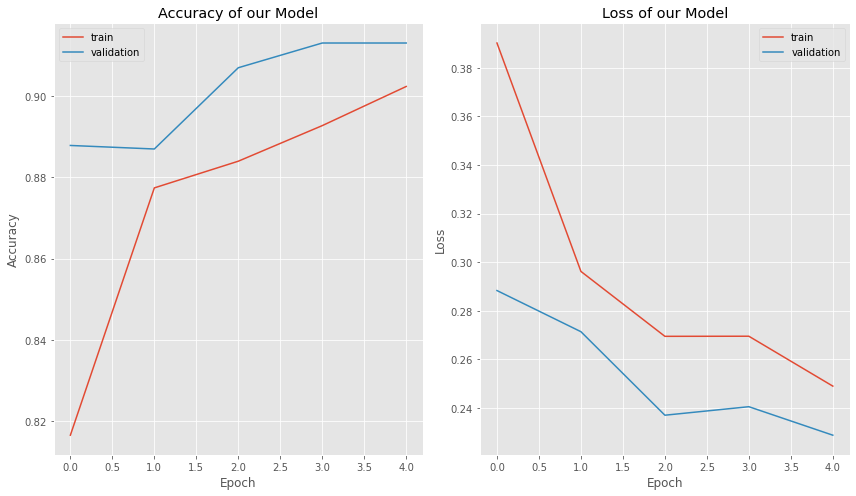

In [20]:
plt.style.use('ggplot')

fig1, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(model_hist.history['accuracy'], label='train')
ax1.plot(model_hist.history['val_accuracy'], label='validation')
ax1.set_title("Accuracy of our Model")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")

ax2.plot(model_hist.history['loss'], label='train')
ax2.plot(model_hist.history['val_loss'], label='validation')
ax2.set_title("Loss of our Model")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

fig1.canvas.set_window_title("Train vs Test")
fig1.set_figheight(7)
fig1.set_figwidth(12)

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()

## Testing our model

In [49]:
testImages = ['4596.png','4640.png','2119.jpg','1404.jpg']

1/1 [==============================] - 0s 73ms/step


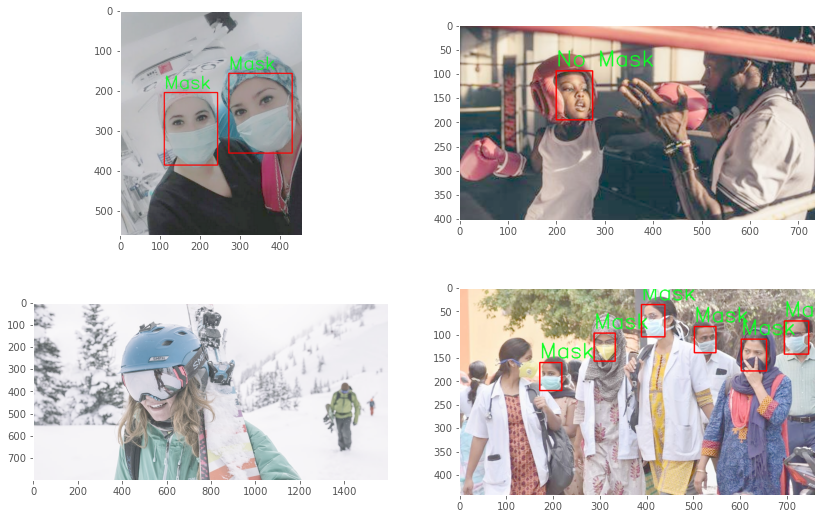

In [50]:
gamma = 2.0
fig = plt.figure(figsize=(14,14))
rowCount = 3
columnCount = 2
axes = []
assign = {'0' : 'Mask', '1': 'No Mask'}
for j, finalImage in enumerate(testImages):
    image = cv2.imread(os.path.join(imageDir, finalImage), 1)
    image = adjustData(image, gamma=gamma)
    (h, w) = image.shape[:2]
    b = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)),
                                1.0, (300, 300), (104.0, 177.0, 123.0))
    cvData.setInput(b)
    disc = cvData.forward()
    for i in range(0, disc.shape[2]):
        try:
            box = disc[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startFeatureData, startLabelData, endFeatureData, endLabelData) = box.astype('int')
            frame = image[startLabelData:endLabelData, startFeatureData:endFeatureData]
            con = disc[0, 0, i, 2]
            
            if con > 0.2:
                finalImage = cv2.resize(frame, (imageSize, imageSize))
                finalImage = np.array(finalImage) / 255.0
                finalImage = finalImage.reshape(1, 124, 124, 3) 
                output = model.predict(finalImage)
                if output > 0.5:
                    label_labelData = 1
                else:
                    label_labelData = 0
                    
                cv2.rectangle(image, (startFeatureData, startLabelData), (endFeatureData, endLabelData),
                             (0, 0, 255), 2)
                cv2.putText(image, assign[str(label_labelData)], 
                           (startFeatureData, startLabelData - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                           1.5, (36, 255, 12), 2)
        except:pass
    axes.append(fig.add_subplot(rowCount, columnCount, j+1))
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)

plt.show()
                